In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

root_path = '/content/gdrive/My Drive/SKT AI Fellowship/모델/in_game_classifier'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Import Model related Packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
print(torch.cuda.memory_allocated(device))

0


Define Model

In [3]:
#------------------------
# Create Model
#------------------------
cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'] # 8 + 3 =vgg11

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(46592, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)

Load Model


In [4]:
new_net = VGG(make_layers(cfg),2,True).to(device)
new_net.load_state_dict(torch.load(root_path + "/result_model/final_model.pth"))

def is_ingame(data_set):
    with torch.no_grad():
      for num, data in enumerate(data_set):
        imgs, label = data
        imgs = imgs.to(device)
        prediction = new_net(imgs)
        return torch.argmax(prediction, 1)

Import Video related Packages

In [ ]:
!pip3 install opencv-python

In [5]:
import os, shutil
def clear_directory(path):
  for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    os.unlink(file_path)

In [6]:
import sys
import argparse
import matplotlib.pyplot as plt
from PIL import Image

import cv2
print(cv2.__version__)

4.1.2


In [13]:
def extractImages(pathIn, pathOut, start = -1, until=-1, frame=60):
    print("Extract Images Start")
    # Initialize local variables
    frame_number = 0
    save_count = 0
    last_check = 0 if start == -1 else start
    saved_frame = []
    success = True

    # Initialize OpenCV
    vidcap = cv2.VideoCapture(root_path + pathIn)
    success,image = vidcap.read()

    fps = vidcap.get(cv2.CAP_PROP_FPS)
    print ("Frames per second  : {0}".format(fps))

    # Initialize PyTorch transform
    trans = transforms.Compose([
      transforms.Resize((240, 426)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    while success:
      success,image = vidcap.read()
      if(not success):
        break
      # Save frame image
      if(frame_number % frame == 0 and frame_number >= frame * last_check):
        cv2.imwrite( root_path + pathOut + "/temp/frame%d.jpg" % frame_number, image)     # save frame as JPEG file
        save_count += 1
        saved_frame.append(frame_number)

      if(frame_number == 67800):
        cv2.imwrite( root_path + pathOut + "/frame%d.jpg" % frame_number, image)
        break


      # Inference saved iamge
      if(save_count % 30 == 0 and save_count > last_check):
        print("Start Inference ", save_count)
        dataset = torchvision.datasets.ImageFolder(root_path + pathOut, transform=trans)
        dataloader = DataLoader(dataset=dataset, batch_size=10, shuffle=False)
        inference_result = is_ingame(dataloader)
        for (index,isInGame) in enumerate(inference_result.tolist()):
          print("Frame {} in game? {}".format(saved_frame[index], isInGame == 1))
          if(isInGame == 1):
            _image = Image.open(root_path + pathOut + "/temp/frame%d.jpg" % saved_frame[index])
            plt.imshow(_image)
        saved_frame[:] = []
        last_check = save_count

        #clear folder
        clear_directory(root_path + pathOut + "/temp")

      if(until != -1 and save_count == until):
        break
      frame_number += 1
    print("Done!")

In [14]:
extractImages("/raw/game2.mp4", "/temp_inference", 500, 1000)

Extract Images Start
Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.968123882641223


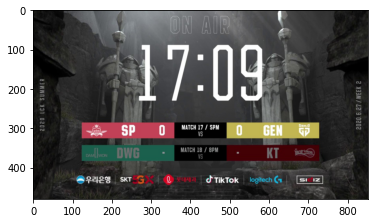

In [ ]:
_image = Image.open(root_path + pathOut + "/temp/frame%d.jpg" % saved_frame[index])
plt.imshow(_image)